* [Загрузка данных](#loading)
* [1. EDA](#EDA)
* [2. Обработка выбросов](#blowout)
* [3. Обработка пропусков](#pass)
* [4. Построение новых признаков](#new_feature)
* [5. Построение графиков](#plot)
* [6. Отбор признаков](#selection)
* [7. Разбиение на train и test](#splitting)
* [8. Построение модели](#model)
* [9. Прогнозирование на тестовом датасете](#test)


#### Подключение библиотек и скриптов

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import numpy as np
import pandas as pd
import pickle #сохранение модели
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

In [4]:
matplotlib.rcParams.update({'font.size': 8})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [9]:
TRAIN_DATASET_PATH = 'real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'real-estate-price-prediction-moscow/test.csv'

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных<a class='loading' id='loading'>

Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [11]:
train_df=pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(10)

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   
5   5804          99    3.0   62.528465   47.103833            6.0      9   
6   8864          44    1.0   33.938750   21.772930            9.0      1   
7  13072          59    2.0   50.391814   32.893256            8.0      8   
8   9951           1    1.0   46.887892   44.628132            1.0     12   
9   8094           6    3.0   79.867477   75.085125            1.0      3   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   
5         9.0       1972   0.012339         B         B        35      5776   
6        12.0       1968   0.232205         B         B        24      4860   
7        17.0       1986   0.019509         B         B        37      7687   
8        20.0       1977   0.007122         B         B         1       264   
9        17.0       2014   0.243205         B         B         5      1564   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962  
5         1        2078.0            2        4       B  161044.944138  
6         1          80.0            0        3       B  142402.739272  
7        11         176.0            5        5       B  326174.175191  
8         0           NaN            0        1       B  160400.401732  
9         0         540.0            0        0       B  194756.023945

In [12]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698122   94.521465           10.0     21   
4997   3912         101    1.0  33.656723   19.003259            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         5.0       1962   0.069660         B         B        31   
4996        27.0       2018   0.060753         B         B        15   
4997         5.0       1966   0.038693         B         B        28   
4998        14.0       1970   0.089040         B         B        33   
4999        17.0       2009   0.194489         B         B        47   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      6119         4           NaN            1        2       B  
4996      2787         2         520.0            0        7       B  
4997      6533         1        1015.0            2        5       B  
4998      7976         5           NaN            0       11       B  
4999      8004         3         125.0            3        5       B

#### Приведение типов

In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### EDA<a class='EDA' id=EDA>
    
    Делаем EDA для:

- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

##### Смотрим основные статистики

In [15]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

<b><i>По результатам статистик выявлены не адекватные значения, такие как: 
- Rooms - не может быть 0, также под подозрение попадает 19 комнат. 
- Площадь квартиры Square не может быть 1,13 кв.м., и площадь 641 кв.м. подозрительна - слишком большой разбег. 
- Жилая площадь и площадь кухни (LifeSquare, KitchenSquare) не могут быть 0 кв.м. и LifeSquare - 7480.59 кв.м., KitchenSquare - 2014 кв.м., скорее всего ошибочно в эту графу ввели год.
- HouseFloor не может быть 0 этажей и 117 этажей является странным, т.к. максимальный этаж квартиры - 42. 
- HouseYear - 20052011 - скорее всего ввели 2 года в одной ячейке. 
 </i></b>

##### Посчитаем для каждого признака, сколько в нем уникальных значений и как часто они встречаются. Сделаем выводы по каждому признаку.

In [16]:
train_df['DistrictId'].unique() 
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
117      1
196      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

Признак DistrictId имеет 205 уникальных значений. Чаще всего встречается 27 идентификационный номер района.

In [17]:
train_df['Rooms'].unique() 
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

<b><i>По признаку 'Rooms' всего 9 уникальных значений. Чаще всего встречаются 2-х комнатные квартиры, чуть меньше 1-х и еще меньше 3-х комнатных квартир. 10 и 19 комнат, наверное возможно, если это большой загородный дом. А вот 0 комнат - быть не может, и таких 8 квартир.


In [18]:
train_df['Square'].unique() 
train_df['Square'].value_counts()
c=(train_df['Square'] < 15)&(train_df['LifeSquare'] > train_df['Square'])
train_df[c]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
161    6782         45    1.0   2.954309    5.257278            1.0      3   
328    4504         27    3.0   4.390331    5.610772            1.0      8   
1401   9487          5    1.0   5.129222    5.549458            1.0      1   
4496  15744         34    1.0   1.988943    2.642219            1.0     21   
4800   7657         38    1.0   4.502784    4.618547            1.0     28   
7033   1748         88    2.0   5.497061   67.628717            1.0     24   
7470  14786          1    1.0   1.136859    4.525736            1.0      3   
8572  10202          6    1.0   2.596351    4.604943            1.0      3   
8805  10527         27    1.0   4.380726   40.805837            1.0     10   
9067  13265          1    3.0   4.823679   79.767964            0.0      6   
9286  12676         81    3.0  13.784865   15.988889            7.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
161          1.0       1977   0.195781         B         B        23   
328         19.0       2016   0.211401         B         B         9   
1401         1.0       1977   0.150818         B         B        16   
4496         4.0       1977   0.069753         B         B        53   
4800         1.0       1977   0.060753         B         B        15   
7033        22.0       1977   0.127376         B         B        43   
7470         1.0       1977   0.007122         B         B         1   
8572        25.0       2014   0.243205         B         B         5   
8805        17.0       2013   0.211401         B         B         9   
9067        17.0       1977   0.007122         B         B         1   
9286         5.0       1960   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
161       5212         6           NaN            3        2       B   
328       1892         0           NaN            0        1       B   
1401      3433         4        2643.0            4        5       B   
4496     13670         4           NaN            1       11       B   
4800      2787         2         520.0            0        7       B   
7033      8429         3           NaN            3        9       B   
7470       264         0           NaN            0        1       B   
8572      1564         0         540.0            0        0       B   
8805      1892         0           NaN            0        1       B   
9067       264         0           NaN            0        1       B   
9286      4756        16        2857.0            5        8       B   

              Price  
161   438005.182323  
328   161379.067034  
1401  369472.403061  
4496  458378.777006  
4800  483283.488083  
7033  412511.088764  
7470  181434.825589  
8572  137597.601458  
8805   97560.720383  
9067  237716.681261  
9286   78388.806186

<b><i>По признаку 'Square' все значения являются уникальными. всего их 10 000. При этом 13 значений менее 15 кв.м. всей площади, что является подозрительно низкими. При чем в некоторых значениях жилая площадь указана больше чем площадь всей недвижимости и таких 11 значений, что является не корректными данными.

In [19]:
train_df['LifeSquare'].unique() 
train_df['LifeSquare'].value_counts()
#train_df[df['LifeSquare'] < 10]

20.151696    1
28.241964    1
23.884805    1
51.826876    1
47.972602    1
            ..
45.455722    1
50.458505    1
42.172028    1
21.993610    1
27.598712    1
Name: LifeSquare, Length: 7887, dtype: int64

<b><i> Признак 'LifeSquare' не имеет повторяющихся значений, все 7887значений уникальные. Из них значение до 10 кв.м. жилой площади являются подозрительно низкими. Таких значений всего 205.

In [20]:
train_df['KitchenSquare'].unique() 
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [21]:
b=train_df['KitchenSquare'] > train_df['Square']
train_df[b]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
2785   6569         27    1.0  38.220258   18.716856           84.0      4   
5273  13703         42    1.0  38.071692   19.723548           73.0      9   
6505  14679         81    1.0  32.276663   19.278394         1970.0      6   
9520  14656         62    1.0  47.100719   46.447960         2014.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2785        17.0       2018   0.011654         B         B         4   
5273        10.0       2006   0.158249         B         B        21   
6505         1.0       1977   0.006076         B         B        30   
9520         1.0       2014   0.072158         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
2785       915         0           NaN            0        0       B   
5273      5731         0           NaN            1        0       B   
6505      5285         0         645.0            6        6       B   
9520       629         1           NaN            0        0       A   

              Price  
2785   99079.960518  
5273  160488.033165  
6505  105539.556275  
9520  108337.484207

<b><i>Самым популярным значением по признаку 'KitchenSquare' является 1кв.м., что не является правильным. вторым и третьим по популярности является значение 8 и 5 кв.м. Не корректными значениями можно считать 2014 и 1970 кв.м., а также 84 и 73, т.к. в этих данных площадь кухни больше чем общая площадь недвижимости.
    

In [22]:
train_df['Floor'].unique() 
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

<b><i>Популярными значениями по признаку 'Floor' являются 4, 5 и 3 этажи. В основном значения кажутся действительными.

In [23]:
train_df['HouseFloor'].unique() 
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

<b><i>В большинстве случаев 'HouseFloor' являются 17, 9 и 12 этажные дома. А вот значение дома в 117 этажей является подозрительным, т.к. максимальное количество этажей в небоскребах "Москва Сити" является 76, т.о. можно сделать вывод, что значение 117 - ошибочное.

In [24]:
train_df['HouseYear'].unique() 
train_df['HouseYear'].value_counts().tail(10)

1948        2
1932        2
1929        2
1910        1
1916        1
1928        1
1947        1
1914        1
4968        1
20052011    1
Name: HouseYear, dtype: int64

<b><i>По возрасту дома, популярным значением оказались дома 1977 года постройки. Значение 20052011 и 4968 являются ошибочными.

In [25]:
train_df['Ecology_1'].unique() 
train_df['Ecology_1'].value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.014334      1
0.012522      1
Name: Ecology_1, Length: 129, dtype: int64

<b><i>'Ecology_1' показывает, что популярное значение 0,007122. Вторым по популярности являются нулевые значения, что возможно является не корректным. Всего 129 уникальных значений.

In [26]:
train_df['Ecology_2'].unique() 
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

<b><i>По данному признаку всего 2 уникальных значения и популярным является значение В.

In [27]:
train_df['Ecology_3'].unique() 
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

<b><i>По данному признаку всего 2 уникальных значения и популярным является значение В.
   

In [28]:
train_df['Social_1'].unique() 
train_df['Social_1'].value_counts()

2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
37    205
24    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

<b><i>По признаку 'Social_1' популярным является значение 2, 1 и 25. Всего 51 уникальное значение.

In [29]:
train_df['Social_2'].unique() 
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

<b><i>По признаку 'Social_2' всего 142 уникальных значения. Значения по данному признаку варьируются от 168 до 19083. Популярными значениями являются 264, 1564 и 629

In [30]:
train_df['Social_3'].unique() 
train_df['Social_3'].value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
93       25
59       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

<b><i>По признаку 'Social_3' всего 30 уникальных значений. Значения по данному признаку варьируются от 0 до 141. Популярными значениями по признаку 'Social_3' являются 0, 1 и 3.

In [31]:
train_df['Healthcare_1'].unique() 
train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

<b><i>По признаку 'Healthcare_1' всего 79 уникальных значений. При этом популярными являются 540, 30 и 1046. Показатели по данному признаку варьируются от 0 до 4849.

In [32]:
train_df['Helthcare_2'].unique() 
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

<b><i>По признаку 'Helthcare_2' всего 7 уникальных значений, которые варьируются от 0 до 6. Популярными из них являются значения 0, 1 и 3. 

In [33]:
train_df['Shops_1'].unique() 
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

<b><i>По признаку 'Shops_1' всего 16 уникальных значений. Популярными из них являются 0, 1 и 5. Значения варьируются в диапазоне от 0 до 23. 

In [34]:
train_df['Shops_2'].unique() 
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

<b><i>По признаку 'Shops_2' всего 2 уникальных значения. Популярным из них является В. 

In [35]:
train_df['Price'].unique() 
train_df['Price'].value_counts()

232830.798767    1
111207.565421    1
108638.637214    1
188774.351894    1
244256.756548    1
                ..
263208.540162    1
190550.982049    1
259715.099993    1
259358.658002    1
166975.682285    1
Name: Price, Length: 10000, dtype: int64

<b><i>По признаку 'Price' все 10 000 значений являются уникальными. Цена варьируется в диапазоне от 59 174 до 633 233 за кв.м.

### 2. Обработка выбросов<a class='blowout' id='blowout'>

<b>Rooms

In [36]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [37]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  115.027311         NaN           10.0      4   
1   3013         22    1.0   39.832524   23.169223            8.0      7   
2   8215          1    3.0   78.342215   47.671972           10.0      2   
3   2352          1    1.0   40.409907         NaN            1.0     10   
4  13866         94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  \
0         0           NaN            0        0       B  305018.871089   
1         1        1183.0            1        0       B  177734.553407   
2         0         240.0            3        1       B  282078.720850   
3         0           NaN            0        1       B  168106.007630   
4         2           NaN            0        6       B  343995.102962   

   Rooms_outlier  
0              0  
1              0  
2              0  
3              0  
4              0

In [38]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [39]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [40]:
train_df['Square'].quantile(.975), train_df['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

In [41]:
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] < train_df['Square'].quantile(.025)) \
             | (train_df['Square'] > train_df['Square'].quantile(.975)), 'Square_outlier'] = 1

In [42]:
train_df.loc[train_df['Square'] < train_df['Square'].quantile(.025), 'Square'] = train_df['Square'].quantile(.025)
train_df.loc[train_df['Square'] > train_df['Square'].quantile(.975), 'Square'] = train_df['Square'].quantile(.975)

#### KitchenSquare

In [43]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[(train_df['KitchenSquare'] == 0) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) \
             | (train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare_outlier'] = 1
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245         NaN           10.0      4   
1   3013         22    1.0   39.832524   23.169223            8.0      7   
2   8215          1    3.0   78.342215   47.671972           10.0      2   
3   2352          1    1.0   40.409907         NaN            1.0     10   
4  13866         94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  \
0         0           NaN            0        0       B  305018.871089   
1         1        1183.0            1        0       B  177734.553407   
2         0         240.0            3        1       B  282078.720850   
3         0           NaN            0        1       B  168106.007630   
4         2           NaN            0        6       B  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  
0              0               1                      0  
1              0               0                      0  
2              0               0                      0  
3              0               0                      0  
4              0               0                      0

In [44]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [45]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) \
            | (train_df['KitchenSquare'] > train_df['Square'])
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [46]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### HouseFloor, Floor

In [47]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [48]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [49]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']].head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
17  1190          8    2.0  49.396000   28.299600            5.0      6   
19   367         45    1.0  42.367289   40.012529            3.0     16   
21  8471         20    3.0  75.611065   47.494621            8.0     11   
24  4717         27    1.0  44.203947         NaN            3.0      2   
25  4521          6    2.0  65.409965         NaN            3.0     18   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
17         5.0       1962   0.458174         B         A        26      4439   
19        14.0       2015   0.195781         B         B        23      5212   
21         9.0       1976   0.019509         B         B        37      7687   
24         0.0       1977   0.072158         B         B         2       629   
25         1.0       1977   0.243205         B         B         5      1564   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  \
17         1        1130.0            1        5       B  186971.926566   
19         6           NaN            3        2       B  250466.980777   
21        11         176.0            5        5       B  366916.246494   
24         1           NaN            0        0       A  135466.559958   
25         0         540.0            0        0       B  191205.272608   

    Rooms_outlier  Square_outlier  KitchenSquare_outlier  
17              0               0                      0  
19              0               0                      0  
21              0               0                      0  
24              0               0                      1  
25              0               0                      0

In [50]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['Floor'] > train_df['HouseFloor']) \
             | (train_df['HouseFloor'] > 25), 'HouseFloor_outlier'] = 1

In [51]:
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 25), 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']

In [52]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear



In [53]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [54]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков<a class='pass' id='pass'>

-<i> Проверим есть ли нулевые значения в датафрейме. заменим такие значения на медиану.

In [55]:
train_df.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
Square_outlier              0
KitchenSquare_outlier       0
HouseFloor_outlier          0
dtype: int64

- <i> Проверю на адекватность признаков. В случае выявления таких данных, обработаю.

#### LifeSquare

In [56]:
train_df['LifeSquare_nan'] = 0
train_df.loc[(train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] > train_df['Square']) | (train_df['LifeSquare'] > 80), 'LifeSquare_nan'] = 1
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

In [57]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [58]:
train_df.loc[train_df['LifeSquare'] > 80, 'LifeSquare'] = train_df['LifeSquare'].median() 

In [59]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 3

In [60]:
train_df.loc[train_df['LifeSquare'] <train_df['KitchenSquare'], 'LifeSquare']=train_df['Square'] - train_df['KitchenSquare'] - 3

#### Healthcare

In [61]:
train_df['Healthcare_1_nan'] = 0
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [62]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()


In [63]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.square_quantile97 = None
        self.square_quantile25 = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.square_quantile97 = X['Square'].quantile(.975)
        self.square_quantile25 = X['Square'].quantile(.025)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        #Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < self.square_quantile25) | (X['Square'] > self.square_quantile97), 'Square_outlier'] = 1
        X.loc[X['Square'] < self.square_quantile25, 'Square'] = self.square_quantile25
        X.loc[X['Square'] > self.square_quantile97, 'Square'] = self.square_quantile97

        

        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] == 0) | (X['KitchenSquare'] > self.kitchen_square_quantile) \
              | (X['KitchenSquare'] > X['Square']), 'KitchenSquare_outlier'] = 1
        
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)\
                    | (X['KitchenSquare'] > X['Square'])
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
              
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 25) | (X['Floor'] > X['HouseFloor']), 'HouseFloor_outlier'] = 1
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 25), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
        
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1']
            
        # LifeSquare
        X['LifeSquare_nan'] = 0
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        X.loc[(X['LifeSquare'].isna()) | (X['LifeSquare'] > X['Square']) | (X['LifeSquare'] > 80), 'LifeSquare_nan'] = 1
       
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3
        X.loc[X['LifeSquare'] < X['KitchenSquare'], 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3
        X.loc[X['LifeSquare'] > 80, 'LifeSquare'] = self.medians['LifeSquare']
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков<a class='new_feature' id='new_feature'>

<b><i> Добавляю новые признаки (фичи) для поиска закономерности отражения цены 

In [64]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

- <i>Предположим, что возраст дома влияет на стоимость квартиры. 

In [65]:
date_t=datetime.now().year

In [66]:
def age_to_cat(X):
    X['age_cat'] = 0
    
    X.loc[(date_t - X['HouseYear']) <= 5, 'age_cat'] = 1
    X.loc[((date_t - X['HouseYear']) > 5) & ((date_t - X['HouseYear']) <= 10), 'age_cat'] = 2
    X.loc[((date_t - X['HouseYear']) > 10) & ((date_t - X['HouseYear']) <= 25), 'age_cat'] = 3
    X.loc[(date_t - X['HouseYear']) > 25, 'age_cat'] = 4
    
    return X

In [67]:
train_df = age_to_cat(train_df)
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  
0               1                 1        2  
1               0                 0        4  
2               0                 0        4  
3               1                 1        4  
4               0                 1        4

- <i>Добавлю еще один признак. Предположив, что чем выше этаж квартиры, тем она дороже

In [68]:
def floor_to_cat(X):
    X['floor_cat'] = 0
    
    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 12), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 12) & (X['Floor'] <= 20), 'floor_cat'] = 4
    X.loc[X['Floor'] > 20, 'floor_cat'] = 5
    
    return X

In [69]:
train_df = floor_to_cat(train_df)
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  
0               1                 1        2          2  
1               0                 0        4          3  
2               0                 0        4          1  
3               1                 1        4          3  
4               0                 1        4          4

In [70]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0         27           851
1          1           652
2         23           565
3          6           511
4          9           294

In [71]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  DistrictSize  
0               1                 1        2          2           851  
1               0                 0        4          3            78  
2               0                 0        4          1           652  
3               1                 1        4          3           652  
4               0                 1        4          4            89

- <i> По признаку ecology_cat можно будет проверить, зависит ли нахождение квартиры в определенной зоне экологии от ее стоимости.

In [72]:
def ecology_to_cat(X):
    X['ecology_cat'] = 0
    
    X.loc[X['Ecology_1'] <= 0.1, 'ecology_cat'] = 1
    X.loc[(X['Ecology_1'] > 0.1) & (X['Ecology_1'] <= 0.2), 'ecology_cat'] = 2
    X.loc[(X['Ecology_1'] > 0.2) & (X['Ecology_1'] <= 0.3), 'ecology_cat'] = 3
    X.loc[(X['Ecology_1'] > 0.3) & (X['Ecology_1'] <= 0.4), 'ecology_cat'] = 4
    X.loc[X['Ecology_1'] > 0.4, 'ecology_cat'] = 5
    
    return X

In [73]:
train_df = ecology_to_cat(train_df)
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  DistrictSize  \
0               1                 1        2          2           851   
1               0                 0        4          3            78   
2               0                 0        4          1           652   
3               1                 1        4          3           652   
4               0                 1        4          4            89   

   ecology_cat  
0            1  
1            2  
2            1  
3            1  
4            3

In [74]:
med_price_by_floor_year = train_df.groupby(['age_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

age_cat  floor_cat  MedPriceByFloorYear
0        1          1        167968.628676
1        1          2        166682.907686
2        1          3        182459.774259
3        1          4        207854.537318
4        1          5        319145.694249

In [75]:
train_df = train_df.merge(med_price_by_floor_year, on=['age_cat', 'floor_cat'], how='left')
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  DistrictSize  \
0               1                 1        2          2           851   
1               0                 0        4          3            78   
2               0                 0        4          1           652   
3               1                 1        4          3           652   
4               0                 1        4          4            89   

   ecology_cat  MedPriceByFloorYear  
0            1        157740.440348  
1            2        196082.478425  
2            1        181917.639413  
3            1        196082.478425  
4            3        193172.107133

In [76]:
med_price_by_age_ecology = train_df.groupby(['age_cat', 'ecology_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByAgeEcology'})
med_price_by_age_ecology.head()

age_cat  ecology_cat  MedPriceByAgeEcology
0        1            1         181207.849454
1        1            2         308767.697649
2        1            3         176343.423198
3        1            4         212146.966092
4        1            5         111003.843244

In [77]:
train_df = train_df.merge(med_price_by_age_ecology, on=['age_cat', 'ecology_cat'], how='left')
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  DistrictSize  \
0               1                 1        2          2           851   
1               0                 0        4          3            78   
2               0                 0        4          1           652   
3               1                 1        4          3           652   
4               0                 1        4          4            89   

   ecology_cat  MedPriceByFloorYear  MedPriceByAgeEcology  
0            1        157740.440348         167395.110806  
1            2        196082.478425         200019.013481  
2            1        181917.639413         192133.221510  
3            1        196082.478425         192133.221510  
4            3        193172.107133         178399.770218

предположим, что цена зависит от расположенных поблизости оздоровительных комплексов - Healthcare_1 

In [78]:
def health_to_cat(X):
    X['health_cat'] = 0
    
    X.loc[X['Healthcare_1'] <= 35, 'health_cat'] = 1
    X.loc[(X['Healthcare_1'] > 35) & (X['Healthcare_1'] <= 50), 'health_cat'] = 2
    X.loc[(X['Healthcare_1'] > 50) & (X['Healthcare_1'] <= 75), 'health_cat'] = 3
    X.loc[(X['Healthcare_1'] > 75) & (X['Healthcare_1'] <= 100), 'health_cat'] = 4
    X.loc[X['Healthcare_1'] > 100, 'health_cat'] = 5
    
    return X

In [79]:
train_df = health_to_cat(train_df)
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  DistrictSize  \
0               1                 1        2          2           851   
1               0                 0        4          3            78   
2               0                 0        4          1           652   
3               1                 1        4          3           652   
4               0                 1        4          4            89   

   ecology_cat  MedPriceByFloorYear  MedPriceByAgeEcology  health_cat  
0            1        157740.440348         167395.110806           5  
1            2        196082.478425         200019.013481           5  
2            1        181917.639413         192133.221510           5  
3            1        196082.478425         192133.221510           5  
4            3        193172.107133         178399.770218           5

In [80]:
med_price_by_ecology_Helth = train_df.groupby(['ecology_cat', 'health_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcologyHelth'})
med_price_by_ecology_Helth.head()

ecology_cat  health_cat  MedPriceByEcologyHelth
0            1           1           186387.319564
1            1           2           387107.550205
2            1           3           247035.708548
3            1           5           192371.633485
4            2           1           183184.886187

In [81]:
train_df = train_df.merge(med_price_by_ecology_Helth, on=['ecology_cat', 'health_cat'], how='left')
train_df.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27    3.0  100.906245   35.527336           10.0    4.0   
1   3013         22    1.0   39.832524   23.169223            8.0    7.0   
2   8215          1    3.0   78.342215   47.671972           10.0    2.0   
3   2352          1    1.0   40.409907   34.409907            3.0   10.0   
4  13866         94    2.0   64.285067   38.562517            9.0   16.0   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          1          1        11      3097   
1         8.0       1966   0.118537          1          1        30      6207   
2        17.0       1988   0.025609          1          1        33      5261   
3        22.0       1977   0.007122          1          1         1       264   
4        16.0       1972   0.282798          1          1        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
0         0         900.0            0        0        1  305018.871089   
1         1        1183.0            1        0        1  177734.553407   
2         0         240.0            3        1        1  282078.720850   
3         0         900.0            0        1        1  168106.007630   
4         2         900.0            0        6        1  343995.102962   

   Rooms_outlier  Square_outlier  KitchenSquare_outlier  HouseFloor_outlier  \
0              0               1                      0                   0   
1              0               0                      0                   0   
2              0               0                      0                   0   
3              0               0                      0                   0   
4              0               0                      0                   0   

   LifeSquare_nan  Healthcare_1_nan  age_cat  floor_cat  DistrictSize  \
0               1                 1        2          2           851   
1               0                 0        4          3            78   
2               0                 0        4          1           652   
3               1                 1        4          3           652   
4               0                 1        4          4            89   

   ecology_cat  MedPriceByFloorYear  MedPriceByAgeEcology  health_cat  \
0            1        157740.440348         167395.110806           5   
1            2        196082.478425         200019.013481           5   
2            1        181917.639413         192133.221510           5   
3            1        196082.478425         192133.221510           5   
4            3        193172.107133         178399.770218           5   

   MedPriceByEcologyHelth  
0           192371.633485  
1           211151.162696  
2           192371.633485  
3           192371.633485  
4           176682.487067

In [82]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_age_ecology = None
        self.med_price_by_ecology_Helth = None
    
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
            
        # floor, year
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.age_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['age_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        # age, ecology
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            df = self.age_to_cat(df)
            df = self.ecology_to_cat(df)
            self.med_price_by_age_ecology = df.groupby(['age_cat', 'ecology_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByAgeEcology'})
            self.med_price_by_age_ecology_median = self.med_price_by_age_ecology['MedPriceByAgeEcology'].median()
            
         # Ecology, Helthecare_1
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            df = self.health_to_cat(df)
            df = self.ecology_to_cat(df)
            self.med_price_by_ecology_Helth = df.groupby(['ecology_cat', 'health_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcologyHelth'})
            self.med_price_by_ecology_Helth_median = self.med_price_by_ecology_Helth['MedPriceByEcologyHelth'].median()
        
        return X
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.age_to_cat(X)   # + столбец age_cat
        X = self.ecology_to_cat(X)   # + столбец ecology_cat
        X = self.health_to_cat(X) # + столбец health_cat
        
        # Target encoding            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['age_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_price_by_age_ecology is not None:
            X = X.merge(self.med_price_by_age_ecology, on=['age_cat', 'ecology_cat'], how='left')
            X.fillna(self.med_price_by_age_ecology_median, inplace=True)
        
        if self.med_price_by_ecology_Helth is not None:
            X = X.merge(self.med_price_by_ecology_Helth, on=['ecology_cat', 'health_cat'], how='left')
            X.fillna(self.med_price_by_ecology_Helth_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        X['floor_cat'] = 0
        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 12), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 12) & (X['Floor'] <= 20), 'floor_cat'] = 4
        X.loc[X['Floor'] > 20, 'floor_cat'] = 5
        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def age_to_cat(self, X):
        X['age_cat'] = 0
        X.loc[(date_t - X['HouseYear']) <= 5, 'age_cat'] = 1
        X.loc[((date_t - X['HouseYear']) > 5) & ((date_t - X['HouseYear']) <= 10), 'age_cat'] = 2
        X.loc[((date_t - X['HouseYear']) > 10) & ((date_t - X['HouseYear']) <= 25), 'age_cat'] = 3
        X.loc[(date_t - X['HouseYear']) > 25, 'age_cat'] = 4
        X['age_cat'].fillna(-1, inplace=True)
        return X
    
    def ecology_to_cat(self, X):
        X['ecology_cat'] = 0
        X.loc[X['Ecology_1'] <= 0.1, 'ecology_cat'] = 1
        X.loc[(X['Ecology_1'] > 0.1) & (X['Ecology_1'] <= 0.2), 'ecology_cat'] = 2
        X.loc[(X['Ecology_1'] > 0.2) & (X['Ecology_1'] <= 0.3), 'ecology_cat'] = 3
        X.loc[(X['Ecology_1'] > 0.3) & (X['Ecology_1'] <= 0.4), 'ecology_cat'] = 4
        X.loc[X['Ecology_1'] > 0.4, 'ecology_cat'] = 5
        X['ecology_cat'].fillna(-1, inplace=True)
        return X

    def health_to_cat(self, X):
        X['health_cat'] = 0
        X.loc[X['Healthcare_1'] <= 35, 'health_cat'] = 1
        X.loc[(X['Healthcare_1'] > 35) & (X['Healthcare_1'] <= 50), 'health_cat'] = 2
        X.loc[(X['Healthcare_1'] > 50) & (X['Healthcare_1'] <= 75), 'health_cat'] = 3
        X.loc[(X['Healthcare_1'] > 75) & (X['Healthcare_1'] <= 100), 'health_cat'] = 4
        X.loc[X['Healthcare_1'] > 100, 'health_cat'] = 5
        X['health_cat'].fillna(-1, inplace=True)
        return X


### 5. Построение графиков<a class='plot' id='plot'>

<b>Построим график распределения целевой переменной. Сделаем выводы.

<AxesSubplot:xlabel='Price', ylabel='Density'>

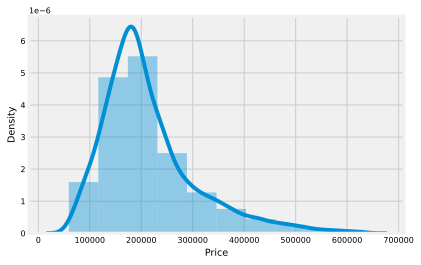

In [83]:
target_name = train_df['Price']
sns.distplot(target_name, bins=10)

<b><i>График целевой переменной с резким ростом и плавным спадом, выбросов не замечено. Больше всего квартир стоимостью в 200 000 за кв/м. 

Построить столбчатые диаграммы распределений для наиболее проблемных признаков (используйте выводы из первого ДЗ). Сделайте по ним выводы.

In [84]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop(['MedPriceByFloorYear', 'MedPriceByAgeEcology', 'MedPriceByEcologyHelth'], axis=1, inplace=True)
df_num_features

Rooms      Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0       3.0  100.906245   35.527336           10.0    4.0        10.0   
1       1.0   39.832524   23.169223            8.0    7.0         8.0   
2       3.0   78.342215   47.671972           10.0    2.0        17.0   
3       1.0   40.409907   34.409907            3.0   10.0        22.0   
4       2.0   64.285067   38.562517            9.0   16.0        16.0   
...     ...         ...         ...            ...    ...         ...   
9995    2.0   49.090728   33.272626            6.0    3.0        12.0   
9996    2.0   64.307684   37.038420            9.0   13.0        13.0   
9997    1.0   32.105183   16.555363            5.0    3.0         5.0   
9998    1.0   32.330292   22.326870            5.0    3.0         9.0   
9999    1.0   35.815476   22.301367            6.0    9.0         9.0   

      Ecology_1  Healthcare_1          Price  
0      0.075424         900.0  305018.871089  
1      0.118537        1183.0  177734.553407  
2      0.025609         240.0  282078.720850  
3      0.007122         900.0  168106.007630  
4      0.282798         900.0  343995.102962  
...         ...           ...            ...  
9995   0.300323         900.0  119367.455796  
9996   0.072158         900.0  199715.148807  
9997   0.460556         900.0  165953.912580  
9998   0.194489         125.0  171842.411855  
9999   0.127376         900.0  177685.627486  

[10000 rows x 9 columns]

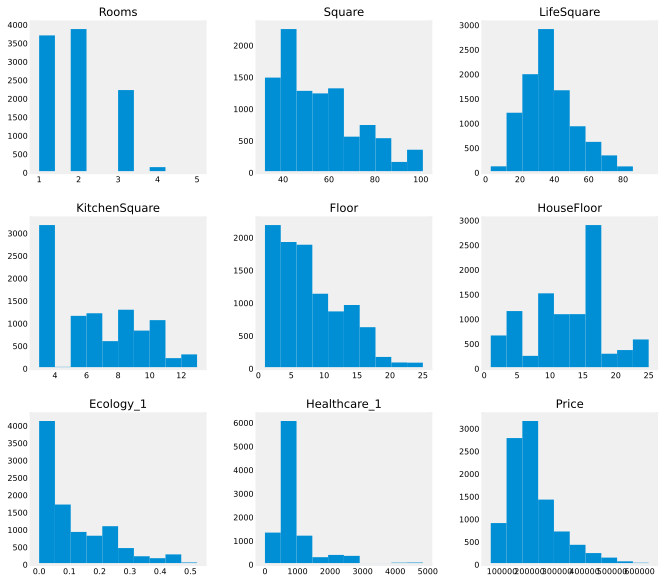

In [85]:
df_num_features.hist(figsize=(10,10), bins=10, grid=False);

<b><i>По полученным графикам можно сделать следующие выводы:

- <i> чаще всего встречаются квартиры с 2 комнатами. Всего таких наблюдейний 4000. Чуть меньше однокомнатных и меньше всего 3-х комнатных. После обработки нулевых значений и выбросов, график визуально подтвердил наблюдения, полученные ранее. 
    
- большая часть квартир с общей площадью в пределах от 40 до 80 кв/м. И совсем мало квартир продается с площадью около 100 кв.м. После обработки признака 'Square' график показывает более корректные данные, без выбросов. 
    
- жилая площадь чаще всего встречается до 40 кв.м., а после 70 кв.м. похоже на выбросы. Признак 'LifeSquare' необходимо рассмотреть подробнее, и заменить выбросы на средние значения.
    
- Самым популярным значением по признаку 'KitchenSquare' является 3кв.м. До обработки выбросов значения после 20 кв.м. были не значительными. На данный момент график выглядит правдоподобно.

- больше всего квартир продается до 10 этажа. Популярными значениями по признаку 'Floor' являются 4, 5 и 3 этажи. В основном значения кажутся действительными. Возможно квартиры этажность, которых после 40, являются выбросами, поэтому были обработаны.
    
-  В большинстве случаев 'HouseFloor' являются 17, 9 и 12 этажные дома. А вот значения после 40 этажей являются подозрительными и скорее всего являются выбросами, поэтому были обработаны. 

- по признаку 'Ecology_1' видим, что больше всего квартир продается со значением до 0,1.   
    

##### матрица кореляций признаков<a class='anchor' id='matrix'>

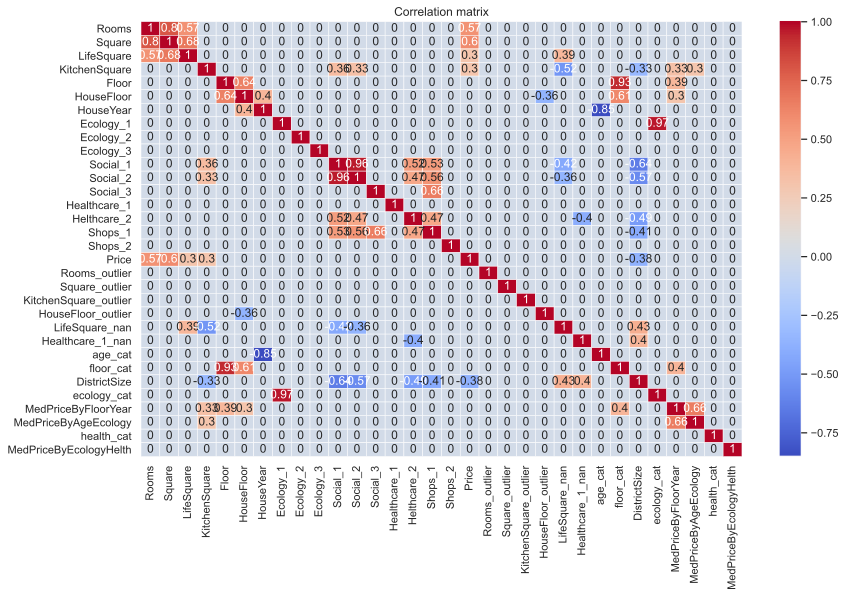

In [86]:
plt.figure(figsize = (12, 8))

sns.set(font_scale=1.0)

corr_matrix=train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

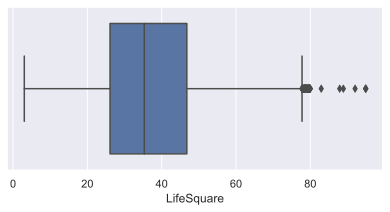

In [87]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [88]:
year_info = pd.Series(train_df['HouseYear'].value_counts(), index=train_df['HouseYear'].unique())

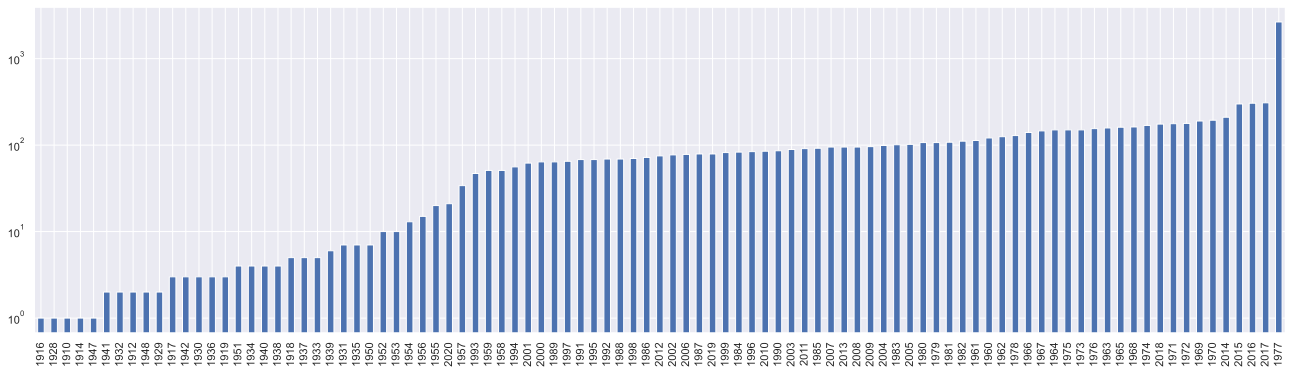

In [89]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
year_info.sort_values().plot(kind="bar", logy=True)

plt.show()

<i>Больше всего домов продается 1977 года постройки. В целом график плавный.

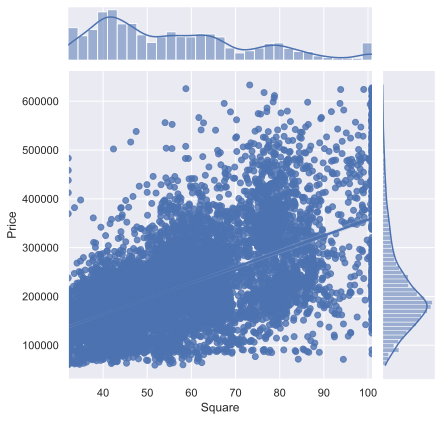

In [90]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Просмотрев на графике влияние разных признаков на целевую переменную, можно сделать вывод, что больше всего на цену кватиры влияет общая площадь квартиры.
Сравнение проводилось с ценой недвижимости и следующих признаков: год постройки дома, общая площадь, колличество комнат, жилая площадь, этаж, экология_1. 
Лучше всего зависимость видна при сравнении с общей площадью квартиры. Видно, что чем меньше площадь, тем ниже стоимость квартиры. С увеличением площадью заметен рост стоимости.

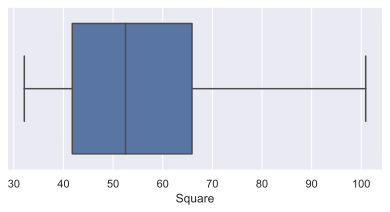

In [91]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

<i>Распределение нормальное

### 6. Отбор признаков<a class='selection' id='selection'>

In [92]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'age_cat',
 'floor_cat',
 'DistrictSize',
 'ecology_cat',
 'MedPriceByFloorYear',
 'MedPriceByAgeEcology',
 'health_cat',
 'MedPriceByEcologyHelth']

In [93]:
feature_names = ['DistrictId', 'Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1',
 'Ecology_2','Ecology_3','Social_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1','Shops_2']

new_feature_names = ['Rooms_outlier', 'KitchenSquare_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 
                     'Healthcare_1_nan', 'age_cat', 'floor_cat', 'DistrictSize', 'ecology_cat', 'MedPriceByFloorYear', 'MedPriceByAgeEcology', 'health_cat', 'MedPriceByEcologyHelth']

target_name = 'Price'

### 7. Разбиение на train и test<a class='splitting' id='splitting'>

In [94]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [95]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [96]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 26), (3300, 26))

In [97]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 35), (3300, 35))

In [98]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

X_train.shape, X_valid.shape

((6700, 31), (3300, 31))

In [99]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

### 8. Построение модели<a class='model' id='model'>

#### Обучение


In [100]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=65,
                                     random_state=20,  
                                     n_estimators=200)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=65,
                          n_estimators=200, random_state=20)

#### Оценка модели

Train R2:	0.851
Test R2:	0.756


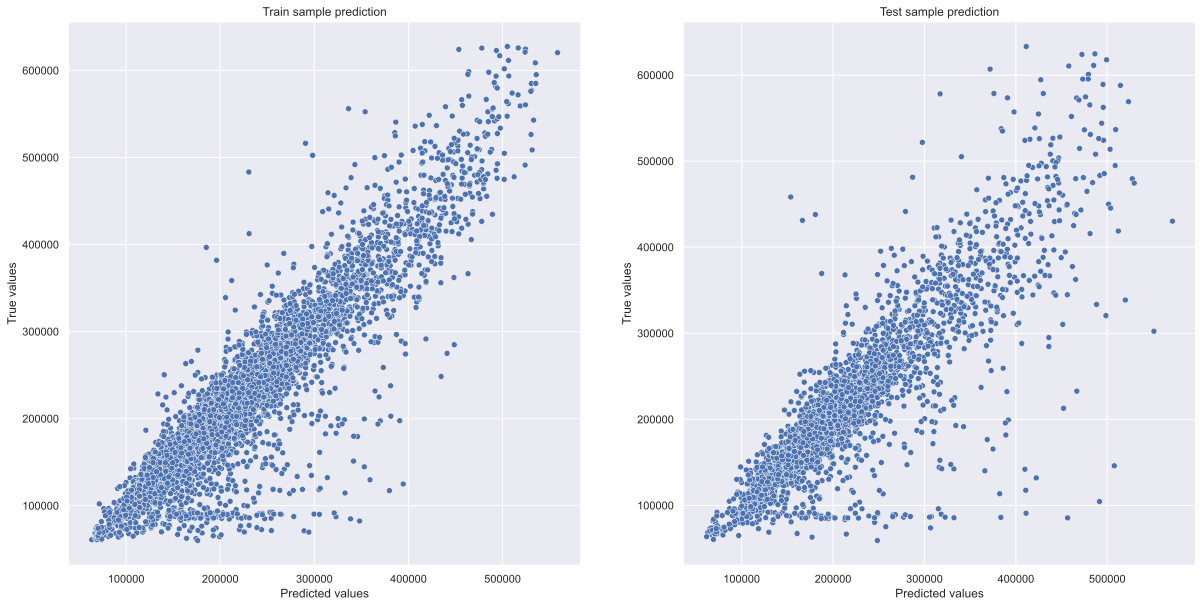

In [101]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [102]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.74726395, 0.70130404, 0.71253428, 0.74395666, 0.74430549])

In [103]:
cv_score.mean()

0.7298728851227708

#### Важность признаков

In [104]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
2                   Square    0.459348
25            DistrictSize    0.226911
13                Social_3    0.058305
12                Social_2    0.038002
8                Ecology_1    0.032080
1                    Rooms    0.025870
11                Social_1    0.024246
7                HouseYear    0.022997
0               DistrictId    0.022776
3               LifeSquare    0.013826
6               HouseFloor    0.013094
4            KitchenSquare    0.011852
14            Healthcare_1    0.010138
27     MedPriceByFloorYear    0.009839
5                    Floor    0.008272
28    MedPriceByAgeEcology    0.006844
16                 Shops_1    0.005866
15             Helthcare_2    0.003988
30  MedPriceByEcologyHelth    0.001545
22        Healthcare_1_nan    0.001492
17                 Shops_2    0.000656
20      HouseFloor_outlier    0.000514
24               floor_cat    0.000494
10               Ecology_3    0.000416
26             ecology_cat    0.000247
21          LifeSquare_nan    0.000178
19   KitchenSquare_outlier    0.000101
23                 age_cat    0.000100
18           Rooms_outlier    0.000000
9                Ecology_2    0.000000
29              health_cat    0.000000

##### Удаление менее значимых признков ухудшили метрику модельки, она составила 0.7301185726656685

#### Испробовав несколько вариантов модели и подсчитав результат, лучше всего себя показала моделька RandomForestRegressor 
#### ниже описаны варианты моделей и их результаты, которые были мной использованы.

* LinearRegression

    результат: 0.5547247799577879
    
    
* RandomForestRegressor \
  1) max_depth=15, # глубина дерева  
     min_samples_leaf=20, # минимальное кол-во наблюдений в листе дерева
     random_state=21, 
     n_estimators=100  # кол-во деревьев
     
     результат:  
                 Train R2:	0.753
                  Test R2:	0.719
                
   2) max_depth=20, # глубина дерева  
      min_samples_leaf=10, # минимальное кол-во наблюдений в листе дерева
      random_state=21, 
      n_estimators=150  # кол-во деревьев
      
      результат:  
                  Train R2:	0.81
                  Test R2:	0.738
                  
    3) max_depth=12, # глубина дерева  
       min_samples_leaf=4, # минимальное кол-во наблюдений в листе дерева
       random_state=21, 
       n_estimators=150  # кол-во деревьев
   
       результат: 
                   Train R2:	0.864
                   Test R2:	0.745
                   
     4) max_depth=30, # глубина дерева  
        min_samples_leaf=4, # минимальное кол-во наблюдений в листе дерева
        random_state=21, 
        n_estimators=150  # кол-во деревьев
     
        результат: 
                     Train R2:	0.887
                     Test R2:	0.748
                   
     5) max_depth=40, # глубина дерева  
        min_samples_leaf=4, # минимальное кол-во наблюдений в листе дерева
        random_state=21, 
        n_estimators=150  # кол-во деревьев
     
        результат:
                     Train R2:	0.887
                     Test R2:	0.748 
                     
                     
     6) max_depth=40, # глубина дерева  
        min_samples_leaf=6, # минимальное кол-во наблюдений в листе дерева
        random_state=21, 
        n_estimators=150  # кол-во деревьев
     
        результат:               
                     Train R2:	0.853
                     Test R2:	0.744
                     
                     
        С помощью  GridSearchCV найдем лучшие параметры к модельке RandomForestRegressor
        (cv=5, estimator=RandomForestRegressor(random_state=21),
        param_grid=[{'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39]),
                          'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                          'n_estimators': [100, 150, 200]}],
             scoring='r2')  
             
        результат: 
        {'max_depth': 17, 'max_features': 8, 'n_estimators': 200}
        метрика составила 0.7258416739931024
        
                     
* GradientBoostingRegressor \
    1) max_depth=15,
       min_samples_leaf=95,
       random_state=21,  
       n_estimators=180)
       
       результат: Train R2:	0.873
                  Test R2:	0.759
                  
    С помощью GridSearchCV найдем лучшие параметры к модельке GradientBoostingRegressor
    ridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [5, 7, 9, 10, 12, 14, 15],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')
                  
    результат: 
    {'max_depth': 5, 'min_samples_leaf': 15, 'n_estimators': 200}\
    метрика составила 0.7307571444258029
    
    Wall time: 6h 35min 47s
    GridSearchCV(cv=KFold(n_splits=5, random_state=20, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29]),
                         'min_samples_leaf': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 89]),
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')
             
     результат: 
     {'max_depth': 6, 'min_samples_leaf': 65, 'n_estimators': 200}\
     метрика: 0.7298728851227708

#### Основываясь на результатах метрики, можно сделать вывод, что лучше всех себя показала моделька GradientBoostingRegressor
#### с параметрами: {'max_depth': 6, 'min_samples_leaf': 65, 'n_estimators': 200}
#### метрика составила 0.7298728851227708

### 9. Прогнозирование на тестовом датасете<a class='test' id='test'>

In [105]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [106]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

test_df = preprocessor.transform(test_df)

test_df.shape

(5000, 26)

In [107]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

test_df = features_gen.transform(test_df)

test_df.shape

(5000, 35)

In [108]:
test_df = test_df[feature_names + new_feature_names]

test_df.shape

(5000, 31)

In [109]:
test_df.isna().sum().sum()

0

In [111]:
submit=pd.read_csv('real-estate-price-prediction-moscow/sample_submission.csv', sep=',')
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [112]:
predicts = gb_model.predict(test_df)
predicts

array([166740.92292909, 135540.76948352, 150734.6446722 , ...,
       146156.86070498, 192180.15384382, 266665.1715015 ])

In [113]:
submit['Price'] = predicts
submit.head()

Id          Price
0  4567  166740.922929
1  5925  135540.769484
2   960  150734.644672
3  3848  115775.499163
4   746  197450.790396

In [114]:
submit.to_csv('gb_submit.csv', index=False)